<font size = 6>Lévy - ARMA - GARCH Risk Model Implement and its Evaluation - Tests</font>
<font size = 4><div style="text-align: right"> Contributor: Haochen Jiang</div></font>
<font size = 4><div style="text-align: right"> May 3, 2022</div></font>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import math
import nlopt
import scipy.stats

import datetime as dt
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web

from scipy import integrate
from statsmodels.tsa.stattools import adfuller, kpss

%matplotlib inline

In [3]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

<font size = 4><strong>Note:</strong><br></font>
<font size = 4>The following code is mainly from the library named "vartests" (Link: https://github.com/rafa-rod/vartests) with some small minor modifications.</font>

In [4]:
from scipy import optimize
from scipy.stats import chi2
import arch
import time
import pygosolnp
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def zero_mean_test(data, true_mu=0, conf_level=0.95):
    ''' Perfom a t-Test if mean of distribution:
         - null hypothesis (H0) = zero
         - alternative hypothesis (H1) != zero
         
        Parameters:
            data (dataframe):   pnl (distribution of profit and loss) or return
            true_mu (float):    expected mean of distribuition
            conf_level (float): test confidence level
        Returns:
            answer (dict):      statistics and decision of the test
    '''

    significance = 1-conf_level
    
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    
    t = (mean - true_mu)/(std/np.sqrt(len(data)))
    '''p<0.05, 2-tail'''
    t_padrao = scipy.stats.t.ppf(1-round(significance/2,4), len(data)-1)
    pvalue = scipy.stats.ttest_1samp(data, popmean=true_mu, alternative='two-sided')[-1]
    H0 = "Mean of distribution = 0"
    if pvalue > significance: #ou t < np.abs(t_padrao): 
        decision = "Fail to rejected H0."
    else:
        decision = "Reject H0."

    answer = {"null hypothesis":H0,
              "decision":decision,
              "t-test statistc":t,
              "t-tabuladed":t_padrao,
              "p-value":pvalue}
    
    return answer

def duration_test(violations, conf_level=0.95):
    
    '''Perform the Christoffersen and Pelletier Test (2004) called Duration Test.
        The main objective is to know if the VaR model responds quickly to market movements
         in order to do not form volatility clusters.
        Duration is time between violations of VaR.
        This test verifies if violations has no memory i.e. should be independent.
        
        Parameters:
            violations (series): series of violations of VaR
            conf_level (float):  test confidence level
        Returns:
            answer (dict):       statistics and decision of the test
    '''
    if isinstance(violations, pd.core.series.Series):
        N = violations[violations==0].count()
        first_hit = violations.iloc[0]
        last_hit = violations.iloc[-1]
    elif isinstance(violations, pd.core.frame.DataFrame):
        N = violations[violations==0].count().values[0]
        first_hit = violations.iloc[0][0]
        last_hit = violations.iloc[-1][0]
        
    duration = [i for i, x in enumerate(violations) if x==1]
    
    diff_duration = np.diff(duration)
    
    TN = len(violations)
    C = np.zeros(len(diff_duration))
    D = np.zeros(len(diff_duration))
    
    if not duration:
        D=np.array([0,0])
        C=np.array([0,0])
    
    if first_hit==0 and duration:
        C = np.append(1,C)
        D = np.append(duration[0], diff_duration) #days until first violation
        
    if last_hit==0 and duration:
        C = np.append(C, 1)
        D = np.append(D, TN-duration[-1]-1)
        
    if N>0 and duration: N = len(D)-1
    else: N=0
      
    def likDurationW(x, D, C, N):
        b = x
        a = ( (N - C[0] - C[N])/(sum(D**b)) )**(1/b)
        lik = C[0]* np.log(pweibull(D[0],a,b,survival=True)) + (1-C[0]) * dweibull(D[0], a, b, log = True) +\
            sum(dweibull(D[1:(N-1)], a, b, log = True) ) + C[N]*np.log(pweibull(D[N],a,b,survival = True) )  +\
                (1 - C[N]) *dweibull(D[N], a, b, log = True)
                
        if np.isnan(lik) or np.isinf(lik): 
            lik = 1e10
        else: lik = -lik
        return lik  
    
    # When b=1 we get the exponential
    def dweibull(D, a, b, log=False):
        # density of Weibull
        pdf = b * np.log(a) + np.log(b) + (b - 1) * np.log(D) - (a * D)**b
        if not log: pdf = np.exp(pdf)
        return pdf
    
    def pweibull(D, a, b, survival = False):
        # distribution of Weibull
        cdf = 1 - np.exp(-(a*D)**b)
        if survival: cdf = 1 - cdf
        return cdf
    
    optimizedBetas = optimize.minimize(likDurationW, x0=[2], args=(D, C, N), method="L-BFGS-B",
                                       bounds= [(0.001, 10)] )
    
    print(optimizedBetas.message)
    
    b = optimizedBetas.x
    uLL = -likDurationW(b, D, C, N)
    rLL = -likDurationW(1, D, C, N)
    LR = 2*(uLL - rLL)
    LRp = 1 - chi2.cdf(LR, 1)
    
    H0 = "Duration Between Exceedances have no memory (Weibull b=1 = Exponential)"
    #i.e. whether we fail to reject the alternative in the LR test that b=1 (hence correct model)
    if LRp<(1-conf_level): 
        decision = "Reject H0"
    else: decision = "Fail to Reject H0"
    
    answer = {"weibull exponential":b,
              "unrestricted log-likelihood":uLL,
              "restricted log-likelihood":rLL,
              "log-likelihood":LR,
              "log-likelihood ratio test statistic":LRp,
              "null hypothesis":H0,
              "decision":decision}
    
    return answer

def failure_rate(violations):
    TN = len(violations)
    N = violations.sum()
    print(f"Failure rate of {round((N/TN)*100,2)}%")
    return N/TN

def kupiec_test(violations, var_conf_level=0.99, conf_level=0.95):
   
    '''Perform Kupiec Test (1995).
       The main goal is to verify if the number of violations, i.e. proportion of failures, is consistent with the
       violations predicted by the model.
       
        Parameters:
            violations (series):    series of violations of VaR
            var_conf_level (float): VaR confidence level
            conf_level (float):     test confidence level
        Returns:
            answer (dict):          statistics and decision of the test
    '''
    if isinstance(violations, pd.core.series.Series):
        v = violations[violations==1].count()
    elif isinstance(violations, pd.core.frame.DataFrame):
        v = violations[violations==1].count().values[0]

    N = violations.shape[0]
    theta= 1-(v/N)

    if v < 0.001:
        V = -2*np.log((1-(v/N))**(N))
    else:
        part1 = ((1-var_conf_level)**(v)) * (var_conf_level**(N-v))
        
        part11= ((1-theta)**(v)) * (theta**(N-v))
        
        fact = math.factorial(N) / ( math.factorial(v) * math.factorial(N-v))
        
        num1 = part1 * fact
        den1 = part11 * fact 
    
        V = -2*(np.log(num1/den1))
    
    chi_square_test = chi2.cdf(V,1) #one degree of freedom
    
    if chi_square_test < conf_level: result = "Fail to reject H0"
    elif v==0 and N<=255 and var_conf_level==0.99: result = "Fail to reject H0"
    else: result = "Reject H0"
        
    return {"statictic test":V, "chi square value":chi_square_test, "p-value": 1-chi_square_test,
            "null hypothesis": f"Probability of failure is {round(1-var_conf_level,3)}",
            "result":result}

def berkowtiz_tail_test(pnl, volatility_window=252, 
                        var_conf_level=0.99, conf_level=0.95, random_seed=443):
    '''Perform Berkowitz Test (2001).
        The goal is to verify if conditional distributions of returns "GARCH(1,1)" 
        used in the VaR Model is adherent to the data.
        In this specific test, we do not observe the whole data, only the tail.
        
        Parameters:
            data (dataframe):        pnl (distribution of profit and loss) or return
            volatility_window (int): window to cabibrate volatility GARCH model
            var_conf_level (float):  VaR confidence level
            conf_level (float):      test confidence level
            random_seed (int):       integer value to set seed to random values of the optimizer
        Returns:
            answer (dict):           statistics and decision of the test
    '''
        
    print("Normalizing returns...")
    conditional_vol, conditional_mean = pd.DataFrame(), pd.DataFrame()
    for t in tqdm(range(pnl.shape[0]-volatility_window+1)):
        am = arch.arch_model(pnl[(t):(volatility_window+t)], vol='garch', dist="Normal", rescale=False).fit(disp="off")
        cond_vol = am.forecast(horizon=1, reindex=False).variance.apply(np.sqrt)
        cond_mean = am.forecast(horizon=1, reindex=False).mean
        conditional_vol = pd.concat([conditional_vol, cond_vol])
        conditional_mean = pd.concat([conditional_mean, cond_mean])
    
    ret_padr = ((pnl.values - conditional_mean.values) / conditional_vol.values)
        
    zeta = scipy.stats.norm.ppf(scipy.stats.norm.cdf(ret_padr))

    alpha=1-var_conf_level
    significance = 1-conf_level
    
    def objective(x):
        #pars[0] => media
        #pars[1] => vol incondicional
        p1 = zeta[np.where(zeta<scipy.stats.norm.ppf((alpha)))]
        p2 = zeta[np.where(zeta>=scipy.stats.norm.ppf(alpha))]*0 + scipy.stats.norm.ppf(alpha)
        return -( sum(np.log(scipy.stats.norm.pdf((p1-x[0])/x[1])/x[1])) + sum( np.log(1-scipy.stats.norm.cdf((p2 - x[0])/x[1]) )) )
        
    print("Optimizing...")
    start = time.time()
    optimum_result = pygosolnp.solve(
                            obj_func=objective,
                            par_lower_limit=[-10, 0.01],
                            par_upper_limit=[10, 3],
                            number_of_simulations=200,  # This represents the number of starting guesses to use
                            number_of_restarts=20,  # This specifies how many restarts to run from the best starting guesses
                            number_of_processes=None,  # None here means to run everything single-processed
                            seed=random_seed,  # Seed for reproducibility, if omitted the default random seed is used (typically cpu clock based)
                            pysolnp_max_major_iter=100,  # Pysolnp property
                            debug=False)
    print("")
    print(f"Elapsed time: {time.time() - start} s")
    
    #all_results = optimum_result.all_results
    #print("; ".join([f"Solution {index + 1}: {solution.obj_value}" for index, solution in enumerate(all_results)]))
    best_solution = optimum_result.best_solution
    #print(f"Best solution {best_solution.obj_value} for parameters {best_solution.parameters}.")
    
    uLL = -best_solution.obj_value
    rLL = -objective([0, 1])
    LR = 2 * (uLL - rLL)
    chid = 1 - scipy.stats.chi2.cdf(LR, 2)
    if (chid < significance):
        decision = "Reject H0"
    else: decision = "Fail to Reject H0"
    H0 = "Distribuition is Normal(0,1)"
    
    answer = {"solution":best_solution,
              "ull":uLL,
              "rll":rLL,
              "LR":LR,
              "chi square test":chid,
              "null hypothesis":H0,
              "decision":decision}
    
    return answer

In [5]:
path = 'D:\\Work\\'

start = dt.datetime(2014, 1, 1)
end = dt.datetime(2021, 12, 31)

## Plot Log Return

<AxesSubplot:xlabel='Log Return', ylabel='Density'>

Text(0.5, 1.0, 'IBM stock Log Return distribution')

Text(0.5, 0, 'percent')

Text(0, 0.5, 'Density')

(array([-20., -15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<AxesSubplot:xlabel='Log Return', ylabel='Density'>

Text(0.5, 1.0, 'VXIBM Log Return distribution')

Text(0.5, 0, 'percent')

Text(0, 0.5, 'Density')

(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

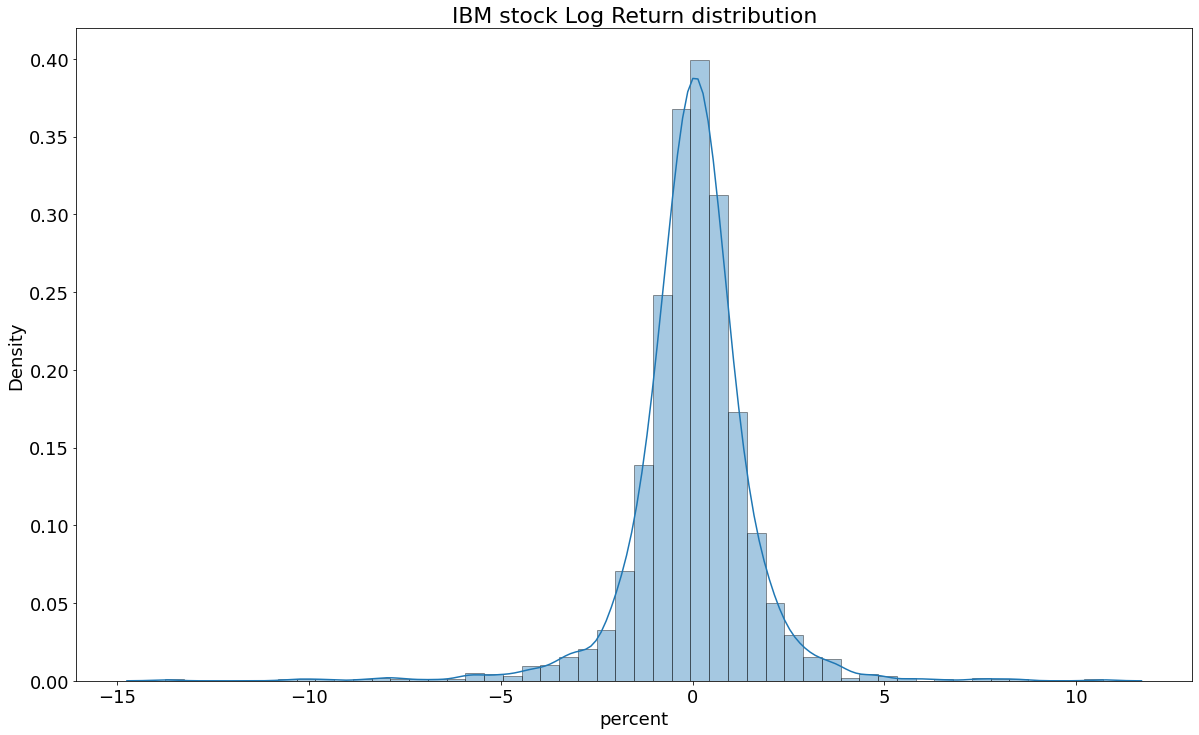

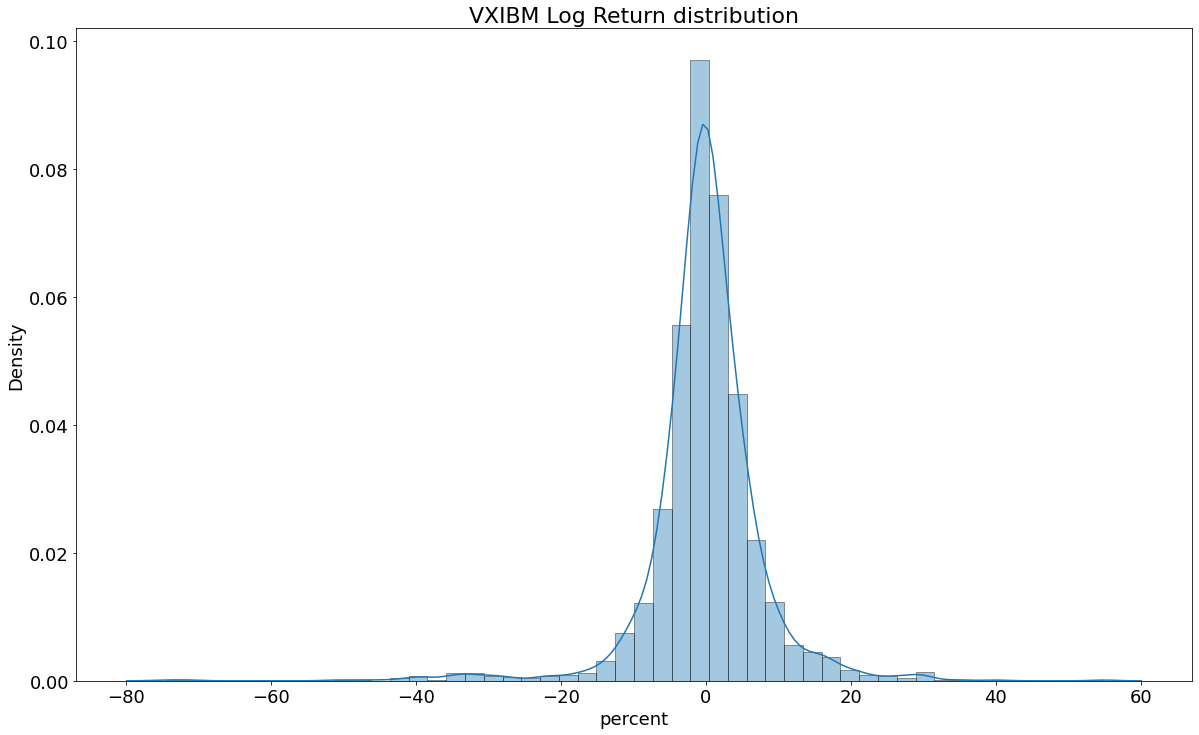

In [16]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
sns.distplot(stock_data["IBM"]["Log Return"] * 100, bins=50, hist_kws={'ec': 'k'}, norm_hist = True)
plt.title("IBM stock Log Return distribution", fontsize=22)
plt.xlabel("percent", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
sns.distplot(vxidx_data["VXIBM"]["Log Return"] * 100, bins=50, hist_kws={'ec': 'k'}, norm_hist = True)
plt.title("VXIBM Log Return distribution", fontsize=22)
plt.xlabel("percent", fontsize=18)
plt.ylabel("Density", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

(array([15706., 16071., 16436., 16801., 17167., 17532., 17897., 18262.,
        18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,   60.,
          80.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Year')

Text(0, 0.5, 'percent')

Text(0.5, 1.0, 'Log Return Series of Two Assets (pct)')

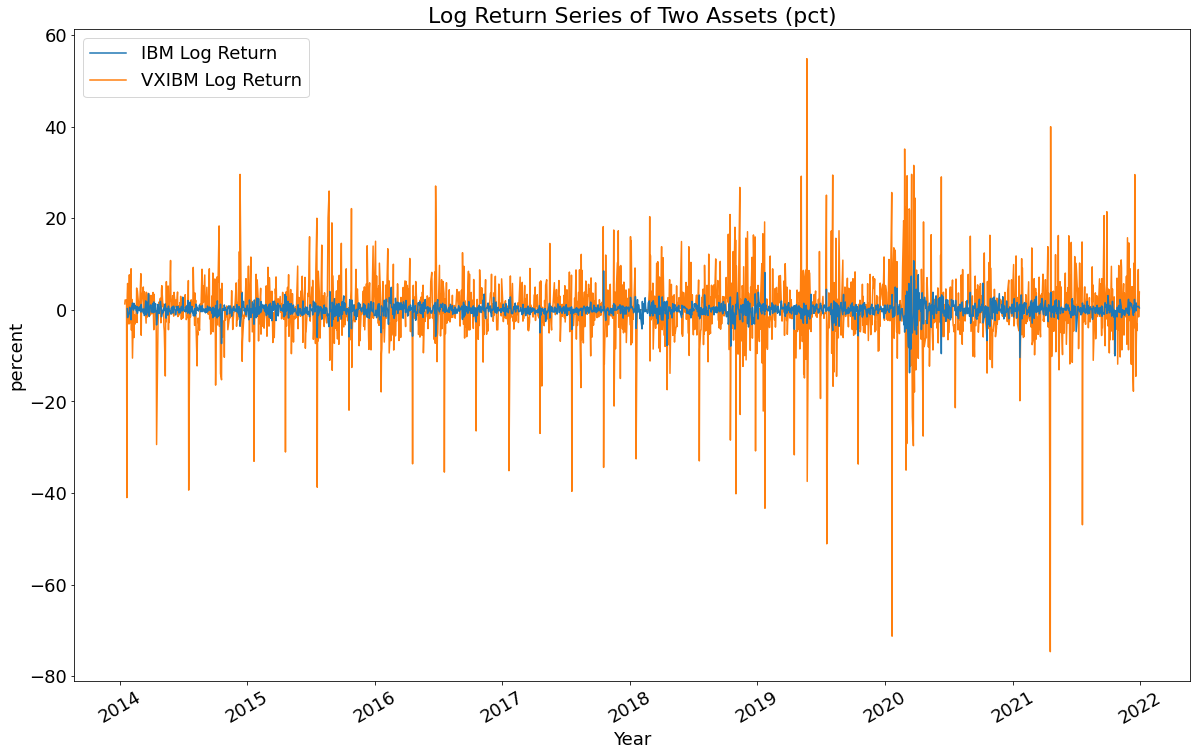

In [17]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(stock_data["IBM"]["Log Return"] * 100, label = "IBM Log Return", zorder = 2)
ax1.plot(vxidx_data["VXIBM"]["Log Return"] * 100, label = "VXIBM Log Return", zorder = 1)
plt.xticks(fontsize=18, rotation = 30)
plt.yticks(fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.ylabel("percent", fontsize=18)
plt.legend(fontsize=18, loc="upper left")
plt.title("Log Return Series of Two Assets (pct)", fontsize=22)

# Tests

In [12]:
IBM_s = pd.read_csv(path + "\Output\\" + "IBM" + "_All_results.csv", index_col = "future_time")
IBM_v = pd.read_csv(path + "\Output\\" + "VXIBM" + "_All_results.csv", index_col = "future_time")

## Stationary Test

In [13]:
adf_test(stock_data["IBM"]["Log Return"])
kpss_test(stock_data["IBM"]["Log Return"])
adf_test(vxidx_data["VXIBM"]["Log Return"])
kpss_test(vxidx_data["VXIBM"]["Log Return"])

Results of Dickey-Fuller Test:
Test Statistic                -1.385595e+01
p-value                        6.867591e-26
#Lags Used                     8.000000e+00
Number of Observations Used    1.991000e+03
Critical Value (1%)           -3.433639e+00
Critical Value (5%)           -2.862993e+00
Critical Value (10%)          -2.567543e+00
dtype: float64
Results of KPSS Test:
Test Statistic           0.043418
p-value                  0.100000
#Lags Used               6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -52.766851
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1999.000000
Critical Value (1%)              -3.433625
Critical Value (5%)              -2.862987
Critical Value (10%)             -2.567540
dtype: float64
Results of KPSS Test:
Te

In [14]:
IBM_s_A_p = []
IBM_v_A_p = []
IBM_s_K_p = []
IBM_v_K_p = []
for i in range(0, 1750):
    IBM_s_A_p.append(adfuller(stock_data["IBM"]["Log Return"][i:i+250])[1])
    IBM_v_A_p.append(adfuller(vxidx_data["VXIBM"]["Log Return"][i:i+250])[1])
    IBM_s_K_p.append(kpss(stock_data["IBM"]["Log Return"][i:i+250])[1])
    IBM_v_K_p.append(kpss(vxidx_data["VXIBM"]["Log Return"][i:i+250])[1])
IBM_s_A_p = pd.DataFrame(IBM_s_A_p, index = IBM_s.index)
IBM_v_A_p = pd.DataFrame(IBM_v_A_p, index = IBM_v.index)
IBM_s_K_p = pd.DataFrame(IBM_s_K_p, index = IBM_s.index)
IBM_v_K_p = pd.DataFrame(IBM_v_K_p, index = IBM_v.index)

([<matplotlib.axis.XTick at 0x1fde2e9e3c8>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Series Last Time')

Text(0, 0.5, 'p-value')

Text(0.5, 1.0, 'IBM & VXIBM p-values series of ACF test')

([<matplotlib.axis.XTick at 0x1fde2f73c08>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Series Last Time')

Text(0, 0.5, 'p-value')

Text(0.5, 1.0, 'IBM & VXIBM p-values series of KPSS test')

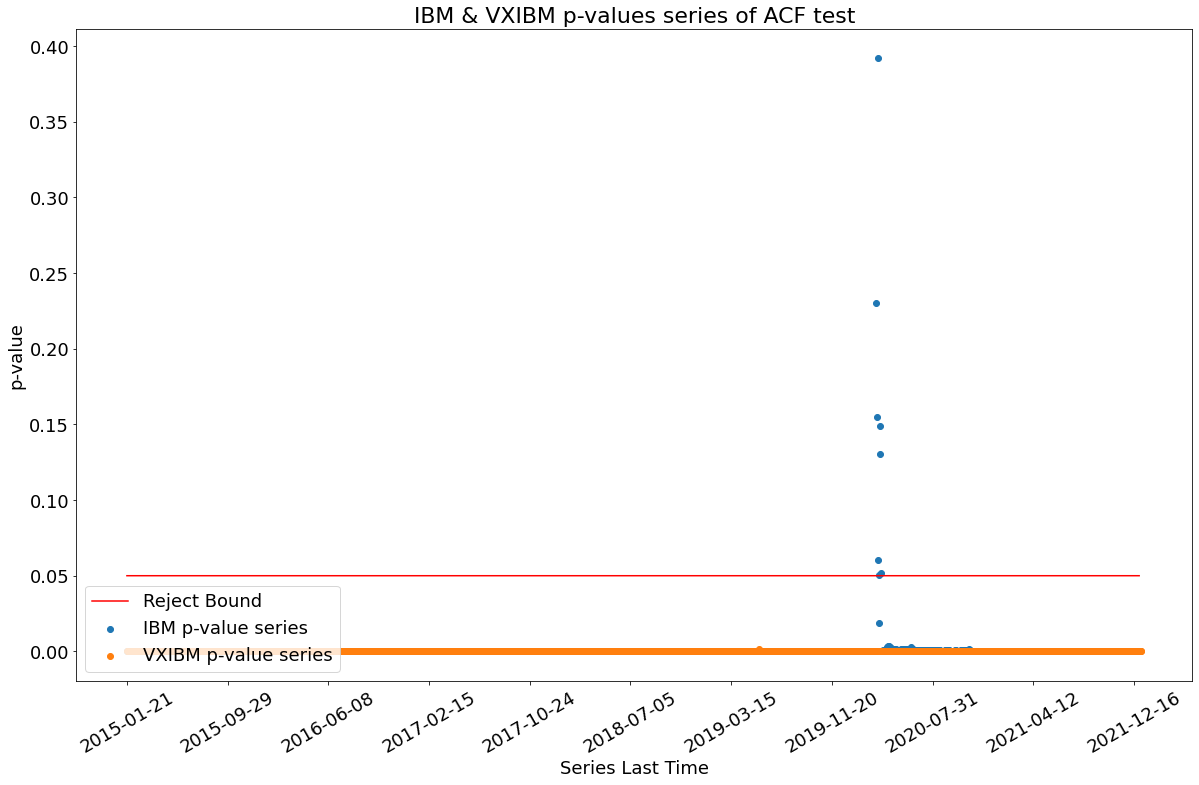

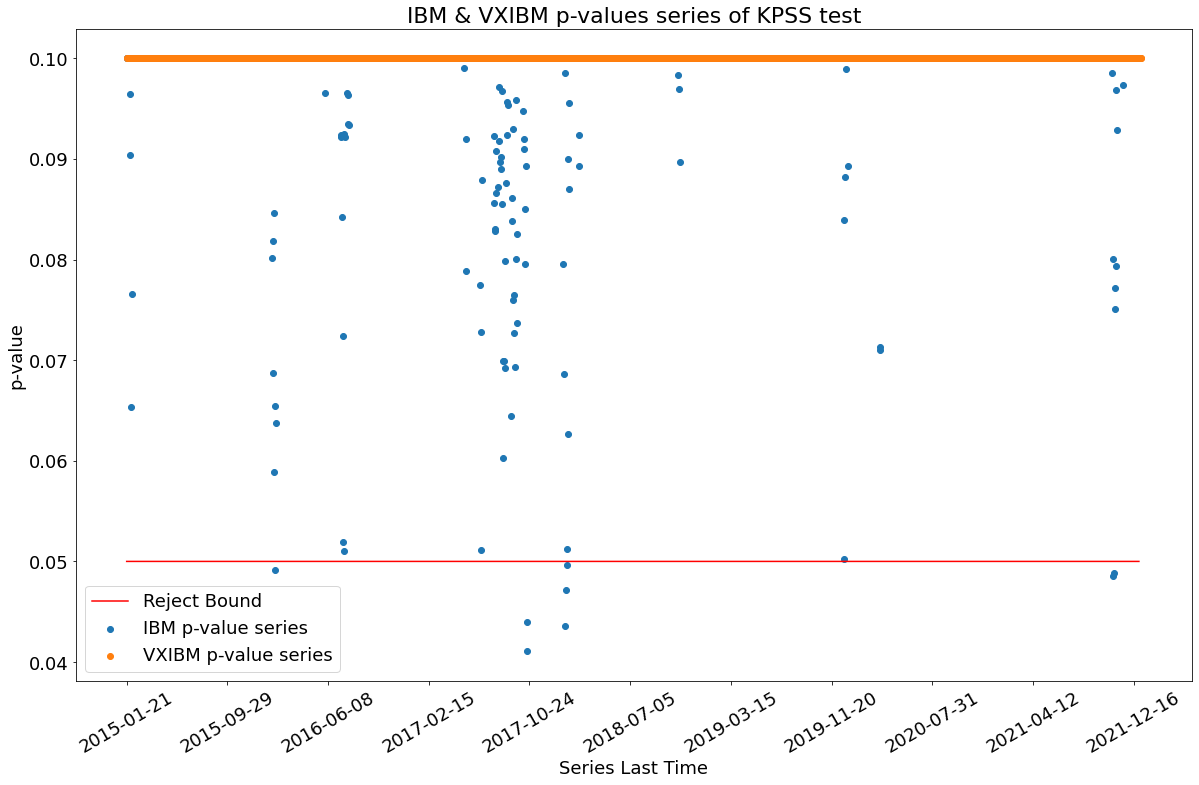

In [15]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(IBM_s_A_p.index, IBM_s_A_p, label = "IBM p-value series")
ax1.scatter(IBM_v_A_p.index, IBM_v_A_p, label = "VXIBM p-value series")
ax1.plot(IBM_s_A_p.index, [0.05] * IBM_s_A_p.shape[0], label = "Reject Bound", color = "r")
my_x_ticks = np.arange(0, IBM_s_A_p[0].shape[0], 174)
plt.xticks(my_x_ticks, fontsize=18, rotation = 30)
plt.yticks(fontsize=18)
plt.xlabel("Series Last Time", fontsize=18)
plt.ylabel("p-value", fontsize=18)
plt.legend(fontsize=18, loc="lower left")
plt.title("IBM & VXIBM p-values series of ACF test", fontsize=22)

fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(IBM_s_K_p.index, IBM_s_K_p, label = "IBM p-value series")
ax1.scatter(IBM_v_K_p.index, IBM_v_K_p, label = "VXIBM p-value series")
ax1.plot(IBM_s_K_p.index, [0.05] * IBM_s_K_p.shape[0], label = "Reject Bound", color = "r")
my_x_ticks = np.arange(0, IBM_s_A_p[0].shape[0], 174)
plt.xticks(my_x_ticks, fontsize=18, rotation = 30)
plt.yticks(fontsize=18)
plt.xlabel("Series Last Time", fontsize=18)
plt.ylabel("p-value", fontsize=18)
plt.legend(fontsize=18, loc="lower left")
plt.title("IBM & VXIBM p-values series of KPSS test", fontsize=22)

## Zero mean and unit variance assumption test

In [18]:
IBM_s_an = pd.read_csv(path + "\\Output\\" + "IBM" + "_ARMA-GARCH_running.csv")
IBM_v_an = pd.read_csv(path + "\\Output\\" + "VXIBM" + "_ARMA-GARCH_running.csv")

In [19]:
IBM_s_Z_p = []
IBM_v_Z_p = []
for i in range(0, 1750):
    IBM_s_Z_p.append(zero_mean_test(IBM_s_an.iloc[:,2 + 3*i])['p-value'])
    IBM_v_Z_p.append(zero_mean_test(IBM_v_an.iloc[:,2 + 3*i])['p-value'])
IBM_s_Z_p = pd.DataFrame(IBM_s_Z_p, index = IBM_s.index)
IBM_v_Z_p = pd.DataFrame(IBM_v_Z_p, index = IBM_v.index)

([<matplotlib.axis.XTick at 0x1fde39ce388>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Series Last Time')

Text(0, 0.5, 'p-value')

Text(0.5, 1.0, 'IBM & VXIBM p-values series of zero-mean and unit-variance assumption test')

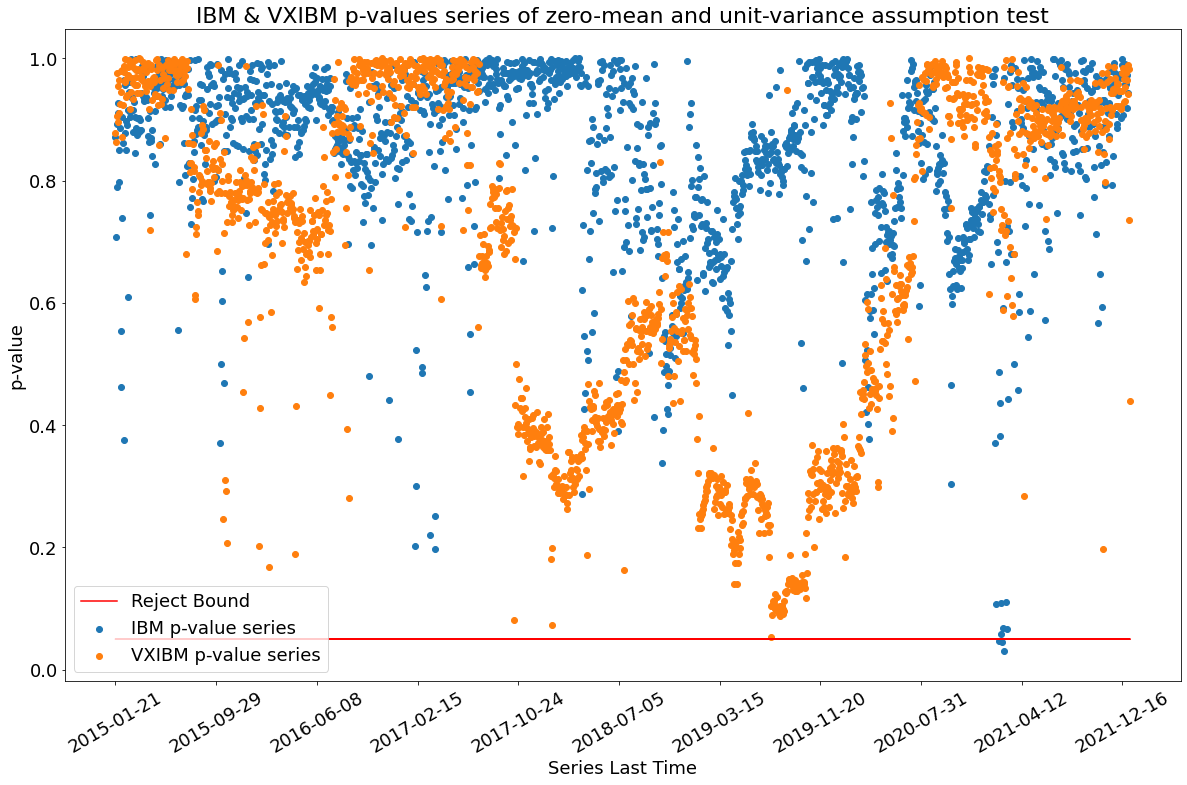

In [20]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
ax1.scatter(IBM_s_Z_p.index, IBM_s_Z_p, label = "IBM p-value series")
ax1.scatter(IBM_v_Z_p.index, IBM_v_Z_p, label = "VXIBM p-value series")
ax1.plot(IBM_v_Z_p.index, [0.05] * IBM_v_Z_p.shape[0], label = "Reject Bound", color = "r")
my_x_ticks = np.arange(0, IBM_s_Z_p[0].shape[0], 174)
plt.xticks(my_x_ticks, fontsize=18, rotation = 30)
plt.yticks(fontsize=18)
plt.xlabel("Series Last Time", fontsize=18)
plt.ylabel("p-value", fontsize=18)
plt.legend(fontsize=18, loc="lower left")
plt.title("IBM & VXIBM p-values series of zero-mean and unit-variance assumption test", fontsize=22)

In [83]:
def check_distribution(n, VIX = False):
    if VIX:
        temp = IBM_v_an
        prefix = "VXIBM"
    else:
        temp = IBM_s_an
        prefix = "IBM"
    fig = plt.figure(figsize=(20, 12))
    ax1 = fig.add_subplot(1, 1, 1)
    std_x = np.linspace(-5, 5, 500)
    std_y = scipy.stats.norm(0, 1).pdf(std_x)
    sns.distplot(temp.iloc[:,2 + 3 * n], bins=50, hist_kws={'ec': 'k'}, label = "Empiricial Distribution")
    ax1.plot(std_x, std_y, label = "Standard Normal Distribution p.d.f.")
    plt.title(prefix + " Residual Empirical distribution - Sample number : " + str(n), fontsize=22)
    plt.xlabel("", fontsize=18)
    plt.ylabel("Density", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

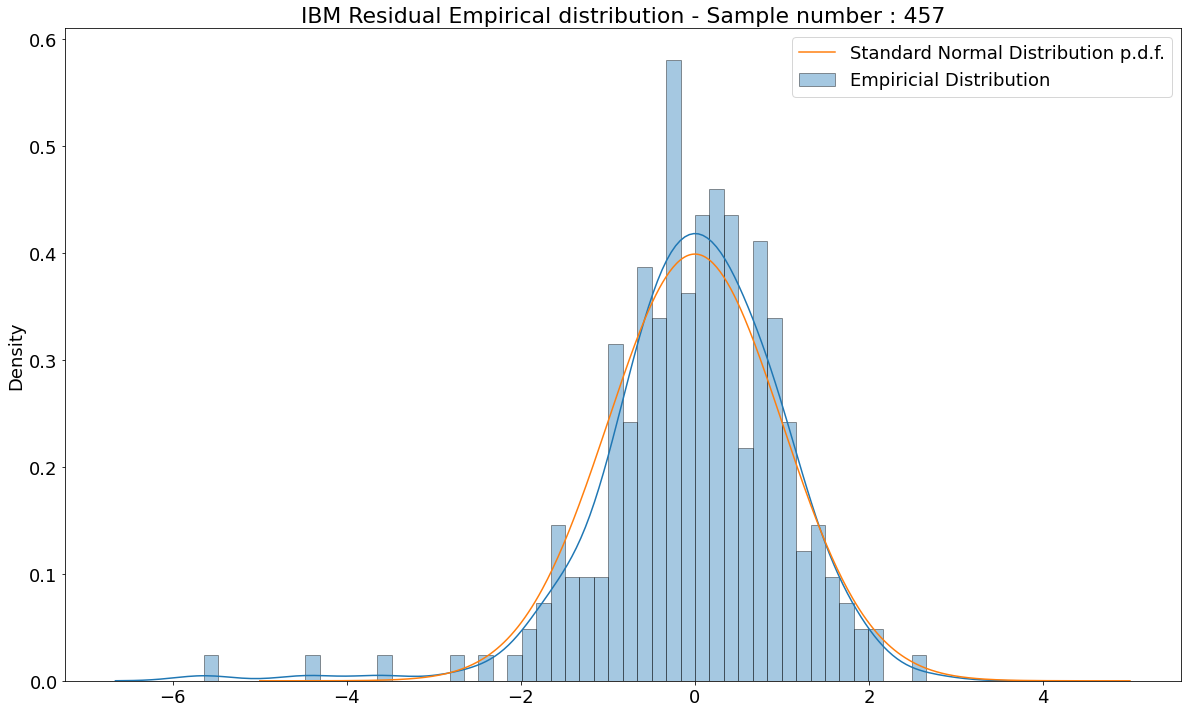

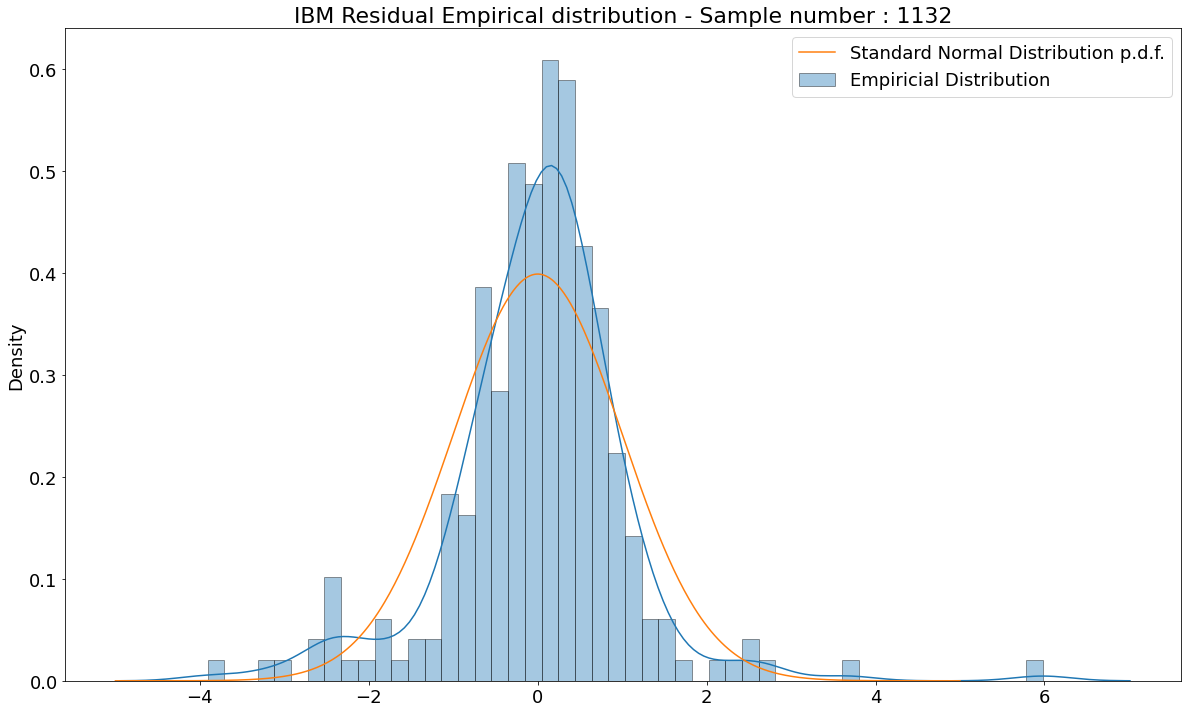

In [84]:
check_distribution(457)
check_distribution(1132)

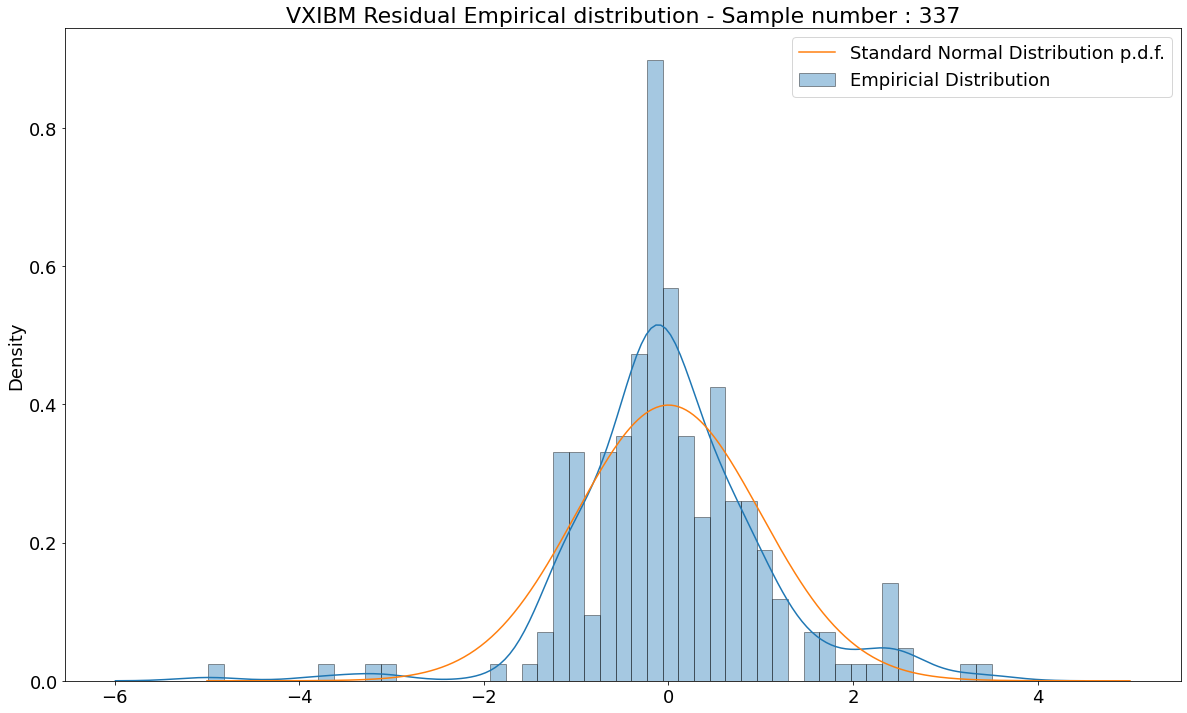

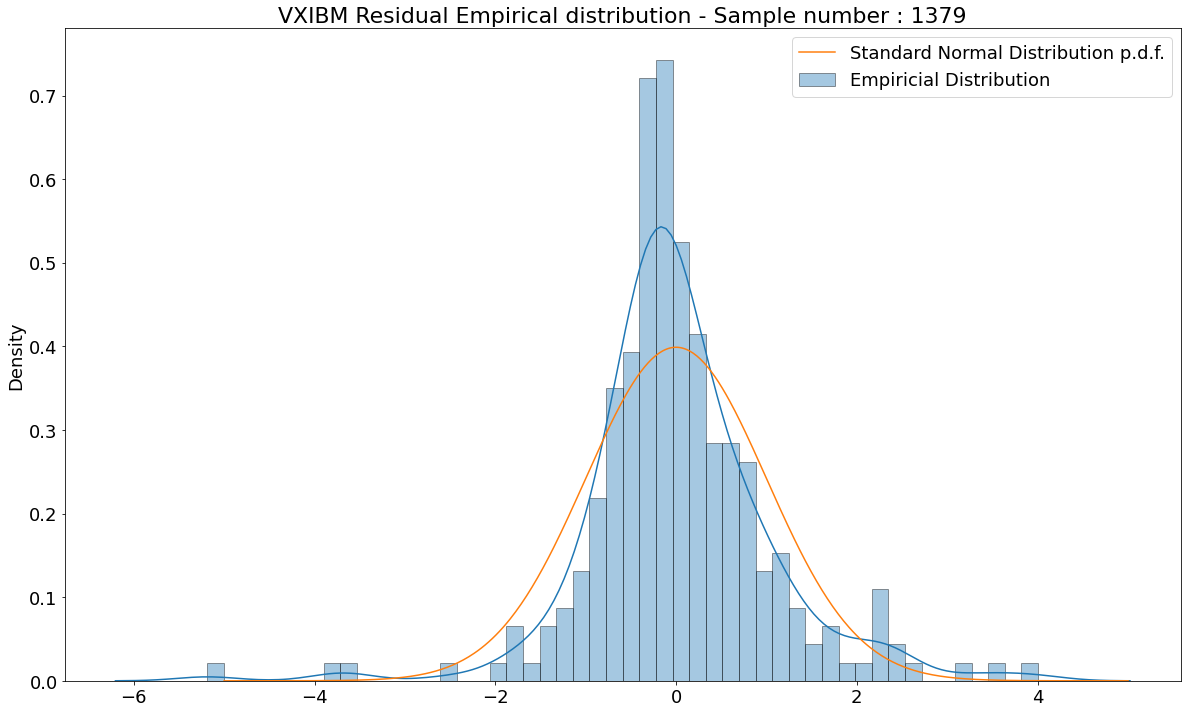

In [85]:
check_distribution(337, True)
check_distribution(1379, True)

## Backtest

In [29]:
scipy.stats.binomtest(work_IBM_s[1].shape[0], n = work_IBM_s[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_s[2].shape[0], n = work_IBM_s[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_s[3].shape[0], n = work_IBM_s[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_s[4].shape[0], n = work_IBM_s[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_s[5].shape[0], n = work_IBM_s[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_s[6].shape[0], n = work_IBM_s[0].shape[0], p = 0.01, alternative='two-sided')

BinomTestResult(k=40, n=1750, alternative='two-sided', proportion_estimate=0.022857142857142857, pvalue=2.847240717338965e-06)

BinomTestResult(k=23, n=1750, alternative='two-sided', proportion_estimate=0.013142857142857144, pvalue=0.1848120244794699)

BinomTestResult(k=26, n=1750, alternative='two-sided', proportion_estimate=0.014857142857142857, pvalue=0.05282424122748834)

BinomTestResult(k=28, n=1750, alternative='two-sided', proportion_estimate=0.016, pvalue=0.01595050003468596)

BinomTestResult(k=16, n=1750, alternative='two-sided', proportion_estimate=0.009142857142857144, pvalue=0.8105342481422563)

BinomTestResult(k=16, n=1750, alternative='two-sided', proportion_estimate=0.009142857142857144, pvalue=0.8105342481422563)

In [30]:
kupiec_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["VaR_norm"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["VaR_nig"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["VaR_gh"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["cVaR_norm"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["cVaR_nig"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["cVaR_gh"]).copy(), var_conf_level=0.99, conf_level=0.95)

{'statictic test': 21.42776689441092,
 'chi square value': 0.9999963258835608,
 'p-value': 3.674116439200681e-06,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Reject H0'}

{'statictic test': 1.588972233355862,
 'chi square value': 0.792526965534376,
 'p-value': 0.20747303446562404,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Fail to reject H0'}

{'statictic test': 3.6283452790169135,
 'chi square value': 0.9431967332147719,
 'p-value': 0.05680326678522807,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Fail to reject H0'}

{'statictic test': 5.383968550700919,
 'chi square value': 0.9796774013668572,
 'p-value': 0.020322598633142785,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Reject H0'}

{'statictic test': 0.13370924858531572,
 'chi square value': 0.2853832567831528,
 'p-value': 0.7146167432168472,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Fail to reject H0'}

{'statictic test': 0.13370924858531572,
 'chi square value': 0.2853832567831528,
 'p-value': 0.7146167432168472,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Fail to reject H0'}

In [31]:
scipy.stats.binomtest(work_IBM_v[1].shape[0], n = work_IBM_v[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_v[2].shape[0], n = work_IBM_v[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_v[3].shape[0], n = work_IBM_v[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_v[4].shape[0], n = work_IBM_v[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_v[5].shape[0], n = work_IBM_v[0].shape[0], p = 0.01, alternative='two-sided')
scipy.stats.binomtest(work_IBM_v[6].shape[0], n = work_IBM_v[0].shape[0], p = 0.01, alternative='two-sided')

BinomTestResult(k=38, n=1750, alternative='two-sided', proportion_estimate=0.021714285714285714, pvalue=1.7104521463703175e-05)

BinomTestResult(k=34, n=1750, alternative='two-sided', proportion_estimate=0.019428571428571427, pvalue=0.00039999565643771944)

BinomTestResult(k=42, n=1750, alternative='two-sided', proportion_estimate=0.024, pvalue=4.2848459642184976e-07)

BinomTestResult(k=34, n=1750, alternative='two-sided', proportion_estimate=0.019428571428571427, pvalue=0.00039999565643771944)

BinomTestResult(k=26, n=1750, alternative='two-sided', proportion_estimate=0.014857142857142857, pvalue=0.05282424122748834)

BinomTestResult(k=26, n=1750, alternative='two-sided', proportion_estimate=0.014857142857142857, pvalue=0.05282424122748834)

In [32]:
kupiec_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["VaR_norm"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["VaR_nig"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["VaR_gh"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["cVaR_norm"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["cVaR_nig"]).copy(), var_conf_level=0.99, conf_level=0.95)
kupiec_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["cVaR_gh"]).copy(), var_conf_level=0.99, conf_level=0.95)

{'statictic test': 18.17281217180777,
 'chi square value': 0.9999798261685888,
 'p-value': 2.0173831411174348e-05,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Reject H0'}

{'statictic test': 12.32049988326587,
 'chi square value': 0.9995519892932605,
 'p-value': 0.00044801070673949894,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Reject H0'}

{'statictic test': 24.887483397432238,
 'chi square value': 0.9999993922425646,
 'p-value': 6.07757435377998e-07,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Reject H0'}

{'statictic test': 12.32049988326587,
 'chi square value': 0.9995519892932605,
 'p-value': 0.00044801070673949894,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Reject H0'}

{'statictic test': 3.6283452790169135,
 'chi square value': 0.9431967332147719,
 'p-value': 0.05680326678522807,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Fail to reject H0'}

{'statictic test': 3.6283452790169135,
 'chi square value': 0.9431967332147719,
 'p-value': 0.05680326678522807,
 'null hypothesis': 'Probability of failure is 0.01',
 'result': 'Fail to reject H0'}

In [33]:
duration_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["VaR_norm"]).copy(), conf_level=0.95)
duration_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["VaR_nig"]).copy(), conf_level=0.95)
duration_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["VaR_gh"]).copy(), conf_level=0.95)
duration_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["cVaR_norm"]).copy(), conf_level=0.95)
duration_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["cVaR_nig"]).copy(), conf_level=0.95)
duration_test((work_IBM_s[0]["future_real_logr"] <= work_IBM_s[0]["cVaR_gh"]).copy(), conf_level=0.95)

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([2.]),
 'unrestricted log-likelihood': -10000000000.0,
 'restricted log-likelihood': -10000000000.0,
 'log-likelihood': 0.0,
 'log-likelihood ratio test statistic': 1.0,
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([1.4048781]),
 'unrestricted log-likelihood': array([-111.35060097]),
 'restricted log-likelihood': -112.94328948131196,
 'log-likelihood': array([3.18537702]),
 'log-likelihood ratio test statistic': array([0.07429986]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([2.]),
 'unrestricted log-likelihood': -10000000000.0,
 'restricted log-likelihood': -10000000000.0,
 'log-likelihood': 0.0,
 'log-likelihood ratio test statistic': 1.0,
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([2.]),
 'unrestricted log-likelihood': -10000000000.0,
 'restricted log-likelihood': -10000000000.0,
 'log-likelihood': 0.0,
 'log-likelihood ratio test statistic': 1.0,
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([2.36295757]),
 'unrestricted log-likelihood': array([-74.02681133]),
 'restricted log-likelihood': -80.07552554165024,
 'log-likelihood': array([12.09742843]),
 'log-likelihood ratio test statistic': array([0.00050491]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([2.36295757]),
 'unrestricted log-likelihood': array([-74.02681133]),
 'restricted log-likelihood': -80.07552554165024,
 'log-likelihood': array([12.09742843]),
 'log-likelihood ratio test statistic': array([0.00050491]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

In [34]:
duration_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["VaR_norm"]).copy(), conf_level=0.95)
duration_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["VaR_nig"]).copy(), conf_level=0.95)
duration_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["VaR_gh"]).copy(), conf_level=0.95)
duration_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["cVaR_norm"]).copy(), conf_level=0.95)
duration_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["cVaR_nig"]).copy(), conf_level=0.95)
duration_test((work_IBM_v[0]["future_real_logr"] <= work_IBM_v[0]["cVaR_gh"]).copy(), conf_level=0.95)

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([1.60064969]),
 'unrestricted log-likelihood': array([-170.0034013]),
 'restricted log-likelihood': -174.48077513100097,
 'log-likelihood': array([8.95474765]),
 'log-likelihood ratio test statistic': array([0.00276749]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([1.67611599]),
 'unrestricted log-likelihood': array([-154.03193418]),
 'restricted log-likelihood': -158.8630794796718,
 'log-likelihood': array([9.66229059]),
 'log-likelihood ratio test statistic': array([0.00188089]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([1.11435627]),
 'unrestricted log-likelihood': array([-189.33614855]),
 'restricted log-likelihood': -189.65310729702142,
 'log-likelihood': array([0.63391749]),
 'log-likelihood ratio test statistic': array([0.42592198]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


{'weibull exponential': array([1.46700049]),
 'unrestricted log-likelihood': array([-155.97837317]),
 'restricted log-likelihood': -158.8630794796718,
 'log-likelihood': array([5.76941262]),
 'log-likelihood ratio test statistic': array([0.01630748]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([1.56470244]),
 'unrestricted log-likelihood': array([-122.38733308]),
 'restricted log-likelihood': -126.05167934859662,
 'log-likelihood': array([7.32869253]),
 'log-likelihood ratio test statistic': array([0.00678624]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


{'weibull exponential': array([1.45343247]),
 'unrestricted log-likelihood': array([-123.59856444]),
 'restricted log-likelihood': -126.05167934859662,
 'log-likelihood': array([4.90622982]),
 'log-likelihood ratio test statistic': array([0.02675999]),
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Reject H0'}

## Choosing Hyperparameter - window size & Exceedance Ratio

In [35]:
def compute_exceedances_simplify1(df, var_confidence = 0.99):
    temp = df[["future_real_logr", "logr_a_nig", "logr_b_nig", "logr_loc_nig", "logr_scale_nig"]]
    temp["VaR_nig"], temp["cVaR_nig"] = [np.nan] * 2
    for i in range(temp.shape[0]):
        a_nig = temp.iloc[i, 1]
        b_nig = temp.iloc[i, 2]
        loc_nig = temp.iloc[i, 3]
        scale_nig = temp.iloc[i, 4]

        nig_dist = scipy.stats.norminvgauss(a_nig, b_nig, loc_nig, scale_nig)
        temp.iloc[i, 5] = nig_dist.ppf(1 - var_confidence)
        temp.iloc[i, 6] = (1 / (1 - var_confidence)) * integrate.quad(lambda x: x * nig_dist.pdf(x), -np.inf, nig_dist.ppf(1 - var_confidence))[0]

        exceedances_VaR_nig = temp[temp["future_real_logr"] <= temp["VaR_nig"]][["VaR_nig"]].copy()
        exceedances_cVaR_nig = temp[temp["future_real_logr"] <= temp["cVaR_nig"]][["cVaR_nig"]].copy()
    return temp, exceedances_VaR_nig, exceedances_cVaR_nig

In [36]:
IBM_s250 = pd.read_csv(path + "\\Output\\" + "IBM_All_results.csv", index_col = "future_time")
IBM_s375 = pd.read_csv(path + "\\Output\\" + "IBM_375_All_results.csv", index_col = "future_time")
IBM_s500 = pd.read_csv(path + "\\Output\\" + "IBM_500_All_results.csv", index_col = "future_time")
IBM_s625 = pd.read_csv(path + "\\Output\\" + "IBM_375_All_results.csv", index_col = "future_time")
IBM_s750 = pd.read_csv(path + "\\Output\\" + "IBM_750_All_results.csv", index_col = "future_time")
IBM_s875 = pd.read_csv(path + "\\Output\\" + "IBM_875_All_results.csv", index_col = "future_time")
IBM_s1000 = pd.read_csv(path + "\\Output\\" + "IBM_1000_All_results.csv", index_col = "future_time")
IBM_s1125 = pd.read_csv(path + "\\Output\\" + "IBM_1125_All_results.csv", index_col = "future_time")
IBM_s1250 = pd.read_csv(path + "\\Output\\" + "IBM_1250_All_results.csv", index_col = "future_time")
IBM_s1375 = pd.read_csv(path + "\\Output\\" + "IBM_1375_All_results.csv", index_col = "future_time")
IBM_s1500 = pd.read_csv(path + "\\Output\\" + "IBM_1500_All_results.csv", index_col = "future_time")
IBM_s1625 = pd.read_csv(path + "\\Output\\" + "IBM_1625_All_results.csv", index_col = "future_time")
IBM_s1750 = pd.read_csv(path + "\\Output\\" + "IBM_1750_All_results.csv", index_col = "future_time")
IBM = [IBM_s250, IBM_s375, IBM_s500, IBM_s625, IBM_s750, IBM_s875, IBM_s1000, IBM_s1125, IBM_s1250, IBM_s1375, IBM_s1500, IBM_s1625, IBM_s1750]
name_IBM =["250", "375", "500", "625", "750", "875", "1000", "1125", "1250", "1375", "1500", "1675", "1750"]

In [37]:
wz_results = {}
for i, s in enumerate(name_IBM):
    wz_results[s] = compute_exceedances_simplify1(IBM[i])

In [38]:
wz_ex_results = {}
for s in name_IBM:
    total = wz_results[s][0].shape[0]
    var_ex = wz_results[s][1].shape[0]
    cvar_ex = wz_results[s][2].shape[0]
    wz_ex_results[s] = (var_ex / total, cvar_ex / total)
wz_ex_results = pd.DataFrame(wz_ex_results).T.rename({0: "", 1: ""}, axis = 1)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([0.006, 0.008, 0.01 , 0.012, 0.014, 0.016, 0.018]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Window Size')

Text(0, 0.5, 'Exceedance Ratio')

Text(0.5, 1.0, 'IBM Log Return 99%VaR & 99%CVaR Exceedance Ratio')

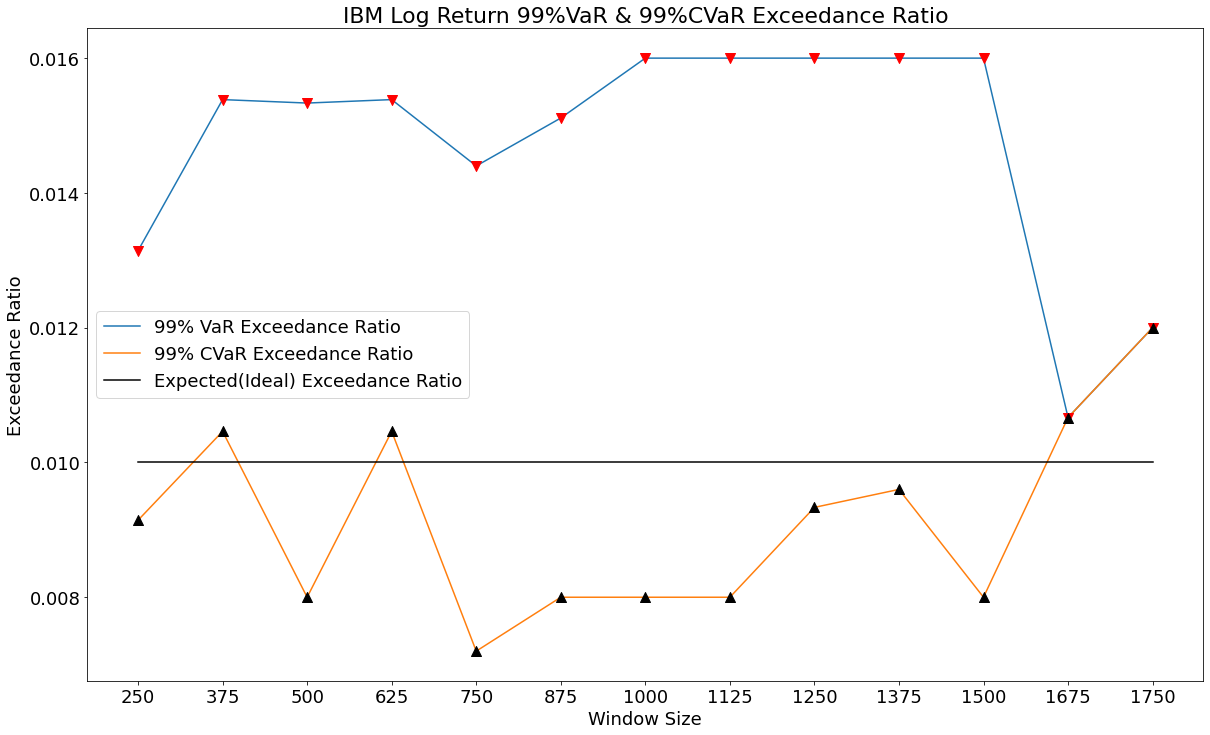

In [39]:
fig = plt.figure(figsize=(20, 12))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(wz_ex_results.iloc[:,0], label = "99% VaR Exceedance Ratio", zorder = 1)
ax1.plot(wz_ex_results.iloc[:,1], label = "99% CVaR Exceedance Ratio", zorder = 1)
ax1.plot(wz_ex_results.iloc[:,1].index, [0.01] * wz_ex_results.iloc[:,1].shape[0], label = "Expected(Ideal) Exceedance Ratio", color = "k", zorder = 1)
ax1.scatter(wz_ex_results.iloc[:,0].index, wz_ex_results.iloc[:,0], color="r", s=100, marker="v", zorder = 2)
ax1.scatter(wz_ex_results.iloc[:,1].index, wz_ex_results.iloc[:,1], color="k", s=100, marker="^", zorder = 2)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Window Size", fontsize=18)
plt.ylabel("Exceedance Ratio", fontsize=18)
plt.legend(fontsize=18)
plt.title("IBM Log Return 99%VaR & 99%CVaR Exceedance Ratio", fontsize=22)